# 뉴스 카테고리 다중분류 프로젝트

본인:  
- Multinominal Naive Bayes
- Support Vector Machine
- Gradient Boosting Classifier

나머지 팀원:  
- Logistic Regression
- Complement Naive Bayes Classifier(CNB)
- Decision Tree
- Random Forest
- Voting
- 1-D CNN  

위의 모델들로 vocab size에 따른 분류 성능을 비교한다.  

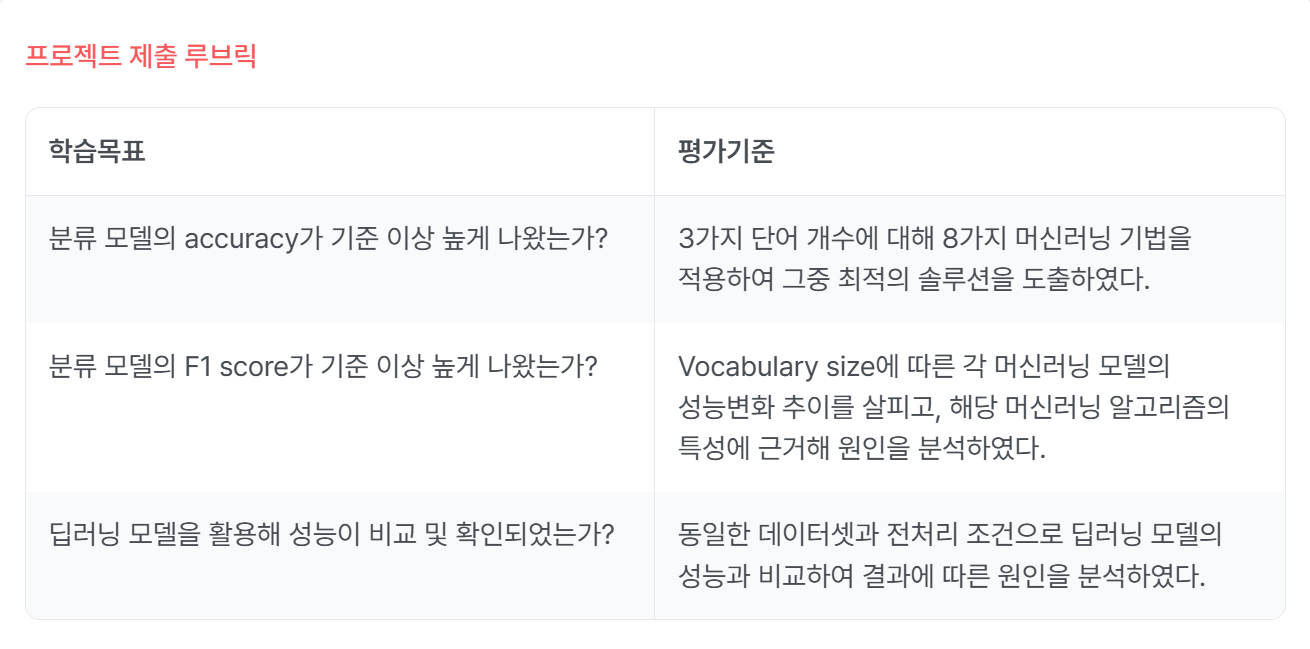

# 라이브러리 및 데이터 로드

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.datasets import reuters

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score

import time
from tqdm import tqdm

In [2]:
# 데이터 로드
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2) # num_words 일단 미지정

# word index 사전
word_index = reuters.get_word_index()

# 0, 1, 2는 pad, sos, unk 토큰이므로 이후의 토큰들에 대해 3을 더해줘야 한다.
index_to_word = {index + 3 : word for word, index in word_index.items()}
index_to_word[0] = "<pad>"
index_to_word[1] = "<sos>"
index_to_word[2] = "<unk>"

# 디코딩
def decode_review(encoded):
    return " ".join(index_to_word.get(i, "<unk>") for i in encoded)

train_texts_all = [decode_review(seq) for seq in x_train]
test_texts_all = [decode_review(seq) for seq in x_test]

# sample 확인
print(train_texts_all[:3])
print(test_texts_all[:3])

['<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3', "<sos> generale de banque sa lt genb br and lt heller overseas corp of chicago have each taken 50 pct stakes in factoring company sa belgo factors generale de banque said in a statement it gave no financial details of the transaction sa belgo factors' turnover in 1986 was 17 5 billion belgian francs reuter 3", '<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share reflect the 

# 벡터화 & 모델 학습 및 평가

In [4]:
# num_words 리스트
num_words_list = [3000, 5000, 10000, 20000]

# num_words별 학습 루프
results = []

for num_words in num_words_list:
    print(f"\n=== num_words = {num_words} ===")
    start_time = time.time()

    # num_words가 바뀔 때마다 정의해줘야 한다.
    vectorizer = TfidfVectorizer(max_features=num_words) # TF-IDF
    X_train = vectorizer.fit_transform(train_texts_all)
    X_test = vectorizer.transform(test_texts_all)

    # 모델 정의
    models = {
        "MultinomialNB": MultinomialNB(),
        "LinearSVM": LinearSVC(C=1, penalty='l2', max_iter=1000, dual=False, random_state=42, verbose=3),
        "GradientBoosting": GradientBoostingClassifier(random_state=42, verbose=3)
    }

    # tqdm으로 모델 진행률 표시
    for model_name, model in tqdm(models.items(), desc="Training models"):
        model_start = time.time()  # 모델별 시작 시간
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        acc = accuracy_score(y_test, preds)
        f1 = f1_score(y_test, preds, average="macro") # 다중분류 문제이므로 디폴트 binary에서 수정했다.

        results.append([num_words, model_name, acc, f1])

        model_time = time.time() - model_start
        print(f"{model_name:18s}  Acc = {acc:.4f},  F1 = {f1:.4f}  (Elapsed: {model_time:.1f}s)")

    loop_time = time.time() - start_time
    print(f"num_words = {num_words} loop finished in {loop_time:.1f}s")


=== num_words = 3000 ===


Training models:   0%|          | 0/3 [00:00<?, ?it/s]

MultinomialNB       Acc = 0.6915,  F1 = 0.1511  (Elapsed: 0.0s)
[LibLinear]

Training models:  67%|██████▋   | 2/3 [00:03<00:01,  1.57s/it]

LinearSVM           Acc = 0.8290,  F1 = 0.6818  (Elapsed: 3.1s)
      Iter       Train Loss   Remaining Time 
         1           1.4754           26.03m
         2     2170902.5562           25.77m
         3     2178222.9292           25.46m
         4 21474141373481801880539660292837384513152868921502682100460605685849575561088186503676484803401944091590656.0000           25.38m
         5 21474141384633204962794874840507152261691603251135244969021063148922017034921457975647312307489489482153984.0000           25.04m
         6 21474141384633204962794874840507152261691603251135244969021063148922017034921457975647312307489489482153984.0000           24.73m
         7 21474141384633204962794874840507152261691603251135244969021063148922017034921457975647312307489489482153984.0000           24.52m
         8 21474141384633204962794874840507152261691603251135244969021063148922017034921457975647312307489489482153984.0000           24.26m
         9 214741413846332049627948748405071522616

Training models: 100%|██████████| 3/3 [26:26<00:00, 528.70s/it]

GradientBoosting    Acc = 0.7671,  F1 = 0.5678  (Elapsed: 1583.0s)
num_words = 3000 loop finished in 1587.3s

=== num_words = 5000 ===



Training models:   0%|          | 0/3 [00:00<?, ?it/s]

MultinomialNB       Acc = 0.6785,  F1 = 0.1156  (Elapsed: 0.0s)
[LibLinear]

Training models:  67%|██████▋   | 2/3 [00:03<00:01,  1.74s/it]

LinearSVM           Acc = 0.8264,  F1 = 0.6773  (Elapsed: 3.4s)
      Iter       Train Loss   Remaining Time 
         1           1.4490           28.00m
         2       40908.7538           27.42m
         3 507386373254545301171270622300401900664239098999186510753534157627850752.0000           27.28m
         4 507386373254545301171270622300401900664239098999186510753534157627850752.0000           26.95m
         5 7135344131474460693918265366179585187782917211401714728716596723401248421855845670800775576570599327399271457967981198058490691584.0000           26.63m
         6 7135344131474460693918265366179585187782917211401714728716596723401248421855845670800775576570599327399271457967981198058490691584.0000           26.45m
         7 7135344131474460693918265366179585187782917211401714728716596723401248421855845670800775576570599327399271457967981198058490691584.0000           26.14m
         8 7135344131474460693918265366179585187782917211401714728716596723401248421855845670800

Training models: 100%|██████████| 3/3 [28:04<00:00, 561.36s/it]

GradientBoosting    Acc = 0.7707,  F1 = 0.5429  (Elapsed: 1680.6s)
num_words = 5000 loop finished in 1685.3s

=== num_words = 10000 ===



Training models:   0%|          | 0/3 [00:00<?, ?it/s]

MultinomialNB       Acc = 0.6576,  F1 = 0.0957  (Elapsed: 0.0s)
[LibLinear]

Training models:  67%|██████▋   | 2/3 [00:06<00:03,  3.10s/it]

LinearSVM           Acc = 0.8299,  F1 = 0.6868  (Elapsed: 6.1s)
      Iter       Train Loss   Remaining Time 
         1           1.4376           29.20m
         2     1451223.6053           29.06m
         3   512394330.6927           28.97m
         4 537662674510088896.0000           28.62m
         5 537662676003913472.0000           28.48m
         6 656173127080591140189446812269867860790577769068215777429704616013840526502807472022452369522335551778874760791498686464.0000           28.14m
         7 656173127080591140189446812269867860790577769068215777429704616013840526502807472022452369522335551778874760791498686464.0000           27.93m
         8 656173127080591140189446812269867860790577769068215777429704616013840526502807472022452369522335551778874760791498686464.0000           27.59m
         9 656173127080591140189446812269867860790577769068215777429704616013840526502807472022452369522335551778874760791498686464.0000           27.36m
        10 656173127080591140189446

Training models: 100%|██████████| 3/3 [30:12<00:00, 604.29s/it]

GradientBoosting    Acc = 0.7738,  F1 = 0.5818  (Elapsed: 1806.7s)
num_words = 10000 loop finished in 1814.1s

=== num_words = 20000 ===



Training models:   0%|          | 0/3 [00:00<?, ?it/s]

MultinomialNB       Acc = 0.6149,  F1 = 0.0752  (Elapsed: 0.1s)
[LibLinear]

Training models:  67%|██████▋   | 2/3 [00:05<00:02,  2.61s/it]

LinearSVM           Acc = 0.8295,  F1 = 0.6888  (Elapsed: 5.2s)
      Iter       Train Loss   Remaining Time 
         1           1.4499           31.80m
         2       95438.0645           31.40m
         3      105523.0476           31.24m
         4 51177387637840133525066847369163319035272223522816.0000           30.82m
         5 95885311931365363565841483911792018150859004841650407902802809941131264.0000           30.64m
         6 145399861704750306753921329797754081505322495089541362540286940152951789708876154961213030271342325626830814869696020480.0000           30.39m
         7 145399861704750306753921329797754081505322495089541362540286940152951789708876154961213030271342325626830814869696020480.0000           30.05m
         8 145399861704750306753921329797754081505322495089541362540286940152951789708876154961213030271342325626830814869696020480.0000           29.79m
         9 145399861704750306753921329797754081505322495089541362540286940152951789708876154961213030271

Training models: 100%|██████████| 3/3 [32:24<00:00, 648.30s/it]

GradientBoosting    Acc = 0.7720,  F1 = 0.5912  (Elapsed: 1939.7s)
num_words = 20000 loop finished in 1946.5s



===== 결과표 =====
    num_words             model  accuracy  f1_macro
0        3000     MultinomialNB  0.691451  0.151085
1        3000         LinearSVM  0.829029  0.681764
2        3000  GradientBoosting  0.767142  0.567806
3        5000     MultinomialNB  0.678540  0.115606
4        5000         LinearSVM  0.826358  0.677293
5        5000  GradientBoosting  0.770703  0.542851
6       10000     MultinomialNB  0.657614  0.095660
7       10000         LinearSVM  0.829920  0.686804
8       10000  GradientBoosting  0.773820  0.581831
9       20000     MultinomialNB  0.614871  0.075212
10      20000         LinearSVM  0.829475  0.688760
11      20000  GradientBoosting  0.772039  0.591218


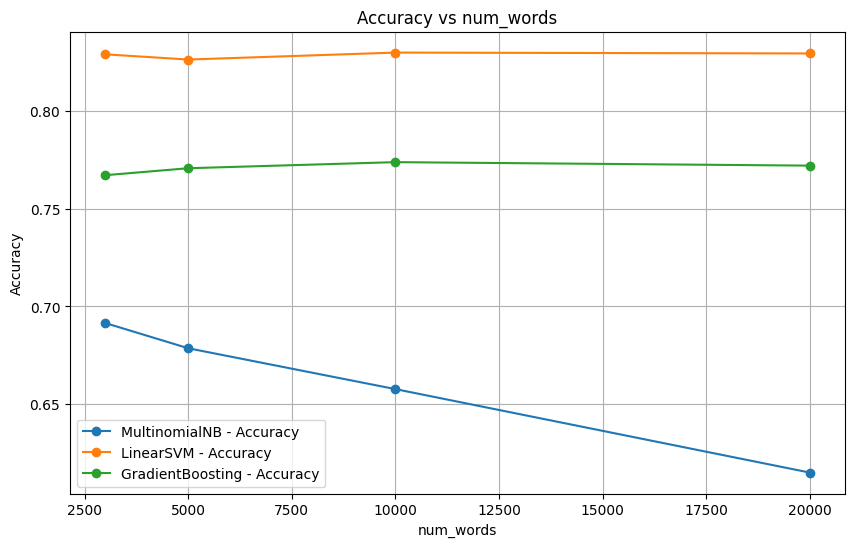

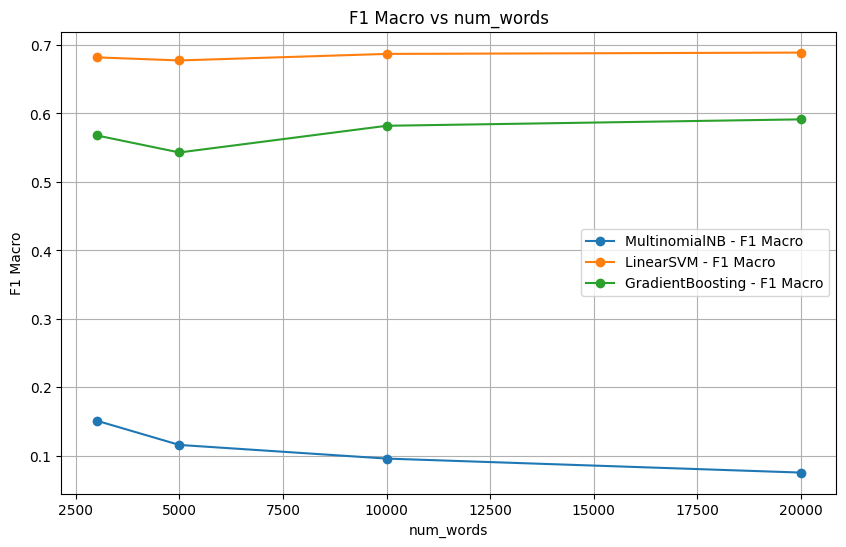

In [5]:
# 결과 DataFrame 생성 + 시각화
df_results = pd.DataFrame(results, columns=["num_words", "model", "accuracy", "f1_macro"])
print("\n===== 결과표 =====")
print(df_results)

# 시각화
plt.figure(figsize=(10,6))
for model_name in df_results["model"].unique():
    subset = df_results[df_results["model"] == model_name]
    plt.plot(subset["num_words"], subset["accuracy"], marker='o', label=f"{model_name} - Accuracy")

plt.title("Accuracy vs num_words")
plt.xlabel("num_words")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
for model_name in df_results["model"].unique():
    subset = df_results[df_results["model"] == model_name]
    plt.plot(subset["num_words"], subset["f1_macro"], marker='o', label=f"{model_name} - F1 Macro")

plt.title("F1 Macro vs num_words")
plt.xlabel("num_words")
plt.ylabel("F1 Macro")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
df_results.to_csv("MNB_SVM_GBC.csv", index=False)